# Proyecto de Regresión Lineal:

In [462]:
# Librerías para evitar la aparición de muchos Warnings al final del proyecto:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignorar las advertencias de convergencia
warnings.filterwarnings("ignore", category=ConvergenceWarning);

# Librería para la declaración y uso de Data Frames:
import pandas as pd

# Librería codificar variables categóricas a numéricas:
from sklearn.preprocessing import LabelEncoder

# Librería para generar un modelo de Regresión Lineal: 
import statsmodels.api as sm

# Librería para realizar operaciones matemáticas: 
import numpy as np

# Librería para poder realizar la partición del conjunto de datos:
from sklearn.model_selection import train_test_split

# Librería para generar un modelo XGBoost:
import xgboost as xgb

# Librería para calcular el VIF: 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Librería para visualizar datos estadísticos: 
import seaborn as sns

# Librería para utilizar un escalador normalizado: 
from sklearn.preprocessing import MinMaxScaler

# Librería para obtener métricas del modelo:
from sklearn.metrics import r2_score, mean_absolute_error


## Paso 1 - Lectura de Datos:

En primer lugar, es necesario **leer y guardar la información** en una variable para poder empezar a trabajar con ella.

Para ello, se ha guaradado el archivo con todos los datos en la ruta: */workspaces/4GeeksAcademy-lineal-regression-python-project-tutorial-clara/data/raw/medical_insurance_cost.csv* y se ha cargado en un Data Frame:

In [463]:
# Lectura del CSV con los datos, dada la ruta donde se guarda el archivo:
df = pd.read_csv ('/workspaces/4GeeksAcademy-lineal-regression-python-project-tutorial-clara/data/raw/medical_insurance_cost.csv');

# Configuración de pandas para mostrar todas las columnas del DataFrame sin truncarlas al visualizarlo
pd.set_option('display.max_columns', None);

# Se muestran las 5 primeras filas del Data Frame
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Una vez se ha cargado correctamente la información en el Data Frame df es interesante evaluar la **cantidad de información** que se tiene. Para ello, se recurre al atributo `.shape` del Data Frame:

In [464]:
# Se utiliza el atributo shape del Data Frame para conocer cuánta información está cargada:
print (f" El conjunto de datos cuenta con información de {df.shape[0]} clientes con total de {df.shape[1]} características sobre ellos");

 El conjunto de datos cuenta con información de 1338 clientes con total de 7 características sobre ellos


## Paso 2 - Análisis Exploratoio de Datos Básico:

Antes de realizar un estudio de la **Regresión Lineal**, es fundamental llevar a acabo un **análisis de los datos **para poder identificar **patrones**, detectar **valores atípicos** y evaluar la distribución de las variables para comprender la **relación entre ellas**.

Por este motivo, se van a realizar distintos pasos cuyo objetivo final es **preparar el conjunto de datos** para poder trabajar con ellos. Este EDA no se explicará tan en detalle como se hizo para el proyecto dedicado únicamente a ello pero se recomienda recurrir a él para explicaciones más detalladas:

### Paso 2.1 - Análisis de Duplicados y Constantes:

Uno de los puntos críticos a la hora de realizar un análisis, es la **existencia de variables / características comunes** a todos los condados, dado que sería **información redundante** y no aportaría valor al estudio, es decir, el análisis sería el mismo aunque no estuviesen como variables y, por lo tanto, se podría prescindir de ellas.

In [465]:
# Se utiliza el método .nunique() para saber la cantidad de columnas con constantes en el Data Frame:
print(f" Hay un total de {(lambda df: (df.nunique() == 1).sum())(df)} columnas en el Data Frame con un valor constante para todos los clientes");

# Se imprime el conteo de valores distintos en cada columna:
print (f" \nPara cada columna del Data Frame, se muestran cuántos valores distintos presentan:");
df.nunique()

 Hay un total de 0 columnas en el Data Frame con un valor constante para todos los clientes
 
Para cada columna del Data Frame, se muestran cuántos valores distintos presentan:


age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

A partir del resultado obtenido, se puede observar que **no hay ninguna constante** en los datos cargados, por lo tanto, **no hay que eliminar ninguna columna**, de momento.

Otro factor determinante a la hora de realizar una limpieza de los datos es detectar si hay **datos repetidos**, aplicado a este caso, si hay clientes duplicados.

In [466]:
# Se utiliza el método .duplicated() para identificar los clientes repetidos dentro del DataFrame:
print(f" Hay un total de {df.duplicated().sum()} clientes duplicados.");

 Hay un total de 1 clientes duplicados.


Como se puede ver, se ha **detectado un cliente duplicado** en el conjunto de datos, por lo que se va a utilziar el método `.drop_duplicates()` para eliminarlo. 

In [467]:
# Se elimina la fila duplicada del Data Frame:
df_clean = df.drop_duplicates();

# Se comprueba que se ha realizado el borrado correctamente:
print (f" Tras la primera limpieza, se ha eliminado {df.shape[0]- df_clean.shape[0]} cliente, quedando en el data set información de {df_clean.shape[0]} clientes con un total de {df_clean.shape[1]} características para cada uno");

 Tras la primera limpieza, se ha eliminado 1 cliente, quedando en el data set información de 1337 clientes con un total de 7 características para cada uno


## Paso 2.2 - Análisis Estadístico:

Una vez ya se ha realizado un **estudio básico** para realizar una **primera limpieza** de datos, a partir del análisis de constantes y duplicados, se puede pasar a **observar estadísticamente la información** y decidir qué datos son poco relevantes.

Para ello, en primer lugar, se va a recurrir al método `.describe()` para tener un **resumen estadístico** de todos los datos, tanto los categóricos como los numéricos.

En este resumen, los puntos más interesantes son, por un lado, los **mínimos y los máximos** en las variables numéricas y el **top value y su frecuencia** para las variables categóricas.

In [468]:
# Descripción estadística básica de todas las columnas del DataFrame:
df_clean.describe(include='all').T # Se traspone para ver de forma más clara los datos

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1337.0,NaN,NaN,NaN,39.222139,14.044333,18.0,27.0,39.0,51.0,64.0
sex,1337,2,male,675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1337.0,NaN,NaN,NaN,30.663452,6.100468,15.96,26.29,30.4,34.7,53.13
children,1337.0,NaN,NaN,NaN,1.095737,1.205571,0.0,0.0,1.0,2.0,5.0
smoker,1337,2,no,1063,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1337,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1337.0,NaN,NaN,NaN,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


En este caso, interesaba principalmente **desechar clientes cuya información aportada no fuese *lógica***, por ejemplo, alguien que presentase una edad exageradamente alta.

Sin embargo, no se ha encontrado **ningún caso extremo**, por lo que no será necesario realizar una limpieza a partir de la información estadística de los datos. 

### Paso 2.3 - Análisis de Nulos:

Uno de los problemas que es habitual encontrarse en el análisis de datos es **variables sin valor**, nulos.

Es por ello que se deben tratar estos casos para o bien **eliminarlos** o bien **rellenarlos** con un valor coherente para cada uno.

En primer lugar, para realizar el análisis, se va a obtener el **porcentaje de clientes que presentan al menos un nulo** en alguna de las características.

In [469]:
# Se comprueba el porcentaje de clientes que presentan al menos un valor nulo:
print(f" El {round(df_clean.isnull().any(axis=1).mean()*100, 2)} % de los clientes presenta, al menos, un valor nulo en alguna de sus características descriptivas");

 El 0.0 % de los clientes presenta, al menos, un valor nulo en alguna de sus características descriptivas


Se comprueba que **no hay ningún valor faltante en nuestro conjunto de datos**, por lo que no se tiene por qué inferir información en ningún caso.

### Paso 2.4  Análisis de Observaciones Influyentes:

En este paso se va a proceder a realizar uno de los puntos clave en el Análisis Exploratorio de Datos, la Identificación de **Observaciones Influyentes**.

Sin embargo, para poder realizar este paso, es necesario que **todas las variables con las que se trabaja sean numéricas**. Por este motivo, en primer lugar, se va a comprobar si hay alguna variable catégorica utilizando el método `.describe()` con el parámetro `include = 'object'`:

In [470]:
# Descripción estadística básica de todas las columnas del DataFrame:
df_clean.describe(include = 'object').T

,count,unique,top,freq
sex,1337,2,male,675
smoker,1337,2,no,1063
region,1337,4,southeast,364


En este caso, no se tiene un criterio determinado por el cual se desee codificar estas variables. Por ello, simplemente se va a utilizar una instancia de un `LabelEncoder()` de la librería `scikit-learn`.

In [471]:
# Se crea una instancia del codificador:
encoder_sex = LabelEncoder();
encoder_smoker = LabelEncoder();
encoder_region = LabelEncoder();

# Se codifican las características categóricas a numéricas:
df_clean['sex_num'] = encoder_sex.fit_transform(df_clean['sex']);
df_clean['smoker_num'] = encoder_smoker.fit_transform(df_clean['smoker']);
df_clean['region_num'] = encoder_region.fit_transform(df_clean['region']);

# Se borran las características categóricas del conjunto de datos:
df_clean.drop(['sex', 'smoker', 'region'], axis = 1, inplace = True);

# Se comprueba que ya no quedan columnas categóricas:
try:
    # Se intenta obtener el resumen de las columnas categóricas
    print(df_clean.describe(include='object')).T;

except Exception:
    # Si hay un error, es porque no hay columnas categóricas:
    print("No hay variables categóricas en el conjunto de datos.");



No hay variables categóricas en el conjunto de datos.


/tmp/ipykernel_673/134788346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sex_num'] = encoder_sex.fit_transform(df_clean['sex']);
/tmp/ipykernel_673/134788346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['smoker_num'] = encoder_smoker.fit_transform(df_clean['smoker']);
/tmp/ipykernel_673/134788346.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

Una vez ya se cuenta con todas las características numéricas, se puede proceder a i**dentificar las observaciones influyentes**.

Para ello, en primer lugar es necesario identificar cuál será, de ahora en adelante la **variable dependiente**, es decir, la variable a *predecir* y separar tanto esta como todas las relacionadas con ella.

En este caso, la **variable a predecir** será la prima del seguro médico (`charges`). Teniendo en cuenta que en el conjunto de datos **no hay ninguna otra características relacionada** directamente con esta, las variables independientes serán todo el resto. 

In [472]:
# Se separa la variable dependiente: 
y = df_clean ['charges'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
X = df_clean.drop(['charges'], axis = 1);

Ahora que se tienen los datos separados, se puede proceder a la identificación de observaciones influyentes a partir del estudio de la **Distancia de Cook**.

Este parámetro ayuda a evaluar la **influencia de una observación mediante los coeficientes de un modelo de regresión lineal**. Si la Distancia de Cook de una observación es alta, significa que dicho dato puede estar alterando de forma muy notable el ajuste del modelo.

In [473]:
# Se incluye el término de ordenada en el origen: 
X = sm.add_constant (X);

# Se ajusta el modelo de Regresión Lineal Ordinaria: 
model_OLS = sm.OLS(y, X).fit();

# Se hace un diagnóstico de influencia y se extrae la Distancia de Cook: 
cooks_distance = model_OLS.get_influence().cooks_distance;

Hay una norma estándar que establece un **punto de corte para la Distancia de Cook**, a partir de la cual está aceptado que la información dentro de un conjunto de datos presente. Dicho límite es la **cuarta parte de la longitud total del DataFrame**:

In [474]:
# Se define el Punto de Corte:
cut_point = 4/len(df_clean);

# Se comprueba cuántas viviendas están por encima de ese punto de corte:
print(f" Hay un total de {len(np.where(cooks_distance[0]>cut_point)[0])} clientes que se encuentran por encima del punto de corte");

# Se eliminan las observaciones influyentes:
df_clean = df_clean.drop(np.where(cooks_distance[0] > cut_point)[0]);

 Hay un total de 97 clientes que se encuentran por encima del punto de corte


### Paso 2.5 - Análisis de Características Relevantes:

Continuando con el proceso de preparación y compresión del conjunto de datos que implica un Análisis Exploratorio. se va a realizar una **Selección de Características**.

Para ello, se va a utilizar un modelo de regresión basado en **XGBoost**, un algoritmo basado en árboles de decisión que utiliza boosting para mejorar la precisión. Por este motivo, el primer paso ha de ser separar el conjunto de datos teniendo una partición para entrenar al modelo (train) y otro para probarlo (test), de forma que se pueda evaluar sin inferir en el modelo su capacidad predictiva.

In [475]:
# Se separa la variable dependiente: 
y = df_clean ['charges'];

# Se guardan las variables independientes en una matrix, eliminando las características relacionadas con la dependiente:
X = df_clean.drop(['charges'], axis = 1);

# Se realiza la partición, explicitando el tamaño del test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42);

# Se crea un modelo de regresión XGBoost y se entrena con los datos del 'train_set':
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42).fit(X_train, y_train);

Una vez se tiene el modelo entrenado, se va a generar un DataFrame que contenga el nombre cada característica y su importancia en valor porcentual:

In [476]:
# Se extrae la importancia de cada característica en porcentaje y se guarda en un Data Frame:
df_imp = pd.DataFrame({'Feature':X_train.columns, 'Importance':xgb_model.feature_importances_*100});

# Se ordena el Data Frame en orden de mayor a menor importancia:
df_imp = df_imp.sort_values(by='Importance', ascending=False);

# Se muestra el Data Frame de las características y su importancia: 
df_imp

,Feature,Importance
4,smoker_num,96.633217
1,bmi,1.443338
0,age,1.037058
2,children,0.371238
5,region_num,0.353478
3,sex_num,0.161669


Como se puede ver, la **característica más importante** que determina la predicción sobre la variable objetivo es **si el cliente es o no fumador**. 

El **resto de características son mucho menos relevantes**, estando algunas por **debajo del 1%**. Estas últimas, se van a eliminar para trabajar únicamente con las variables realmente importantes sobre la variable a predecir. 

In [477]:
# Se establece un punto de corte: 
cut_point_characteristics = 1;

# Se seleccionan las características con más de 1% de importancia:
X_train = X_train[df_imp[df_imp.Importance>1]['Feature'].values];
X_test = X_test[df_imp[df_imp.Importance>1]['Feature'].values];

### Paso 2.6 - Análisis del VIF:

Para continuar con el Análisis Exploratorio de los Datos, se va proceder a utilizar una métrica para **detectar la colinealidad entre las variables independientes**, el factor de Inflación de Varianza (**VIF**), pudiendo así saber si una variable puede predecirse de manera lineal usando otras variables y **evitar redundancias** en el conjunto de datos.

In [478]:
# Se calcula el VIF utilizando la función variance_inflation_factor de cada una de las características del conjunto de datos:
vif = pd.Series([variance_inflation_factor(X_train.corr().values, i) for i in range(X_train.corr().shape[1])], index=X_train.columns);
vif

smoker_num    1.016008
bmi           1.056454
age           1.043022
dtype: float64

La forma correcta de interpretar un VIF es la siguiente:

**VIF** = 1 : No hay colinealidad
1 < **VIF** < 5 : Colinealidad Mderada
**VIF** > 5 : Colinealidad Alta

Por este motivo, siguiendo dicho criterio, **no existe colinealidad entre las características** restantes en el conjunto de datos. Para realizar una comprobación adicional, se va a proceder a visualizar de forma clara las relaciones lineales a través de un **mapa de color de la matriz de correlación**:

<Axes: >

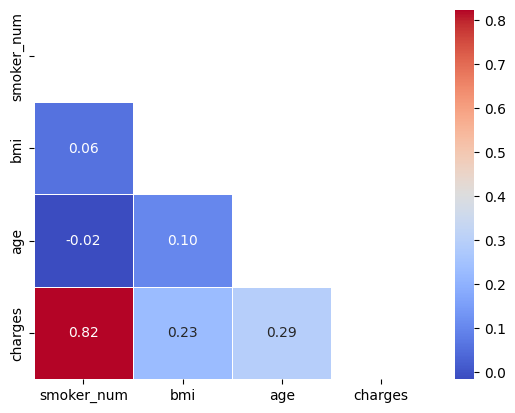

In [479]:
# Se hace una copia del train set:
X_corr = X_train.copy();

# Se añade la columna de precios:
X_corr['charges'] = y_train;

# Se calcula la matrix de correlación entre todas las columnas:
corr = X_corr.corr();

# Se crea el mapa de color:
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

Tal y como se ha estudiado durante la selección de características, la prima del seguro médico (nuestra variable objetivo) parece depender de si la persona es o no fumadora. 

## Paso 3 - Escalado de Variables:

Una vez se tiene el **conjunto de datos depurado**, se debe preparar para **utilizar algoritmos de aprendizaje supervisado** como una **Regresión Lineal**, dado que así se puede asegurar que todos los cdatos **contribuyan de manera equitativa al modelo**.

En este caso, como se cuenta con **una variable binaria**, se ha optado por realizar un escalado a través del `MinMaxScaler()`. De esta forma, en primer lugar, se ha de **identificar qué características son binarias**:

In [480]:
# Se identifican las variables binarias:
binary_cols = X_train[(X_train == 0)|(X_train == 1)].dropna(axis=1).columns;
binary_cols

Index(['smoker_num'], dtype='object')

Ahora que ya se conoce qué variable es binaria, se pueden **tratar y escalar el resto** de forma separada:

In [481]:
# Se seleccionan las columnas NO binarias:
X_train_nobin = X_train.drop(binary_cols, axis = 1);
X_test_nobin = X_test.drop(binary_cols, axis = 1);

# Se instancia un escalador normalizado y se ajusta con los datos de entrenamiento:
scaler = MinMaxScaler().fit(X_train_nobin);

# Se escalan los datos:
X_train_nobin_sc = scaler.transform(X_train_nobin);
X_test_nobin_sc = scaler.transform(X_test_nobin);

Una vez realizado el escalado, ya se tienen **todas las características con valores binarios**, por lo que se pueden **añadir las que se habían detectado en este rango** desde un principio:

In [482]:
# Se añaden todas las características y se guardan en un Data Frame de nuevo:
X_train_sc = pd.concat([pd.DataFrame(X_train_nobin_sc, columns = X_train_nobin.columns), X_train[binary_cols].reset_index(drop=True)], axis=1);
y_train = y_train.reset_index(drop = True) 
 
X_test_sc = pd.concat([pd.DataFrame(X_test_nobin_sc, columns = X_test_nobin.columns), X_test[binary_cols].reset_index(drop=True)], axis=1);
y_test = y_test.reset_index(drop = True) 

X_train_sc

,bmi,age,smoker_num
0,0.124522,0.130435,1
1,0.158247,0.021739,0
2,0.358820,0.282609,0
3,0.478973,0.326087,1
4,0.297105,0.086957,0
...,...,...,...
987,0.459858,0.347826,0
988,0.391589,0.152174,0
989,0.389132,0.434783,0
990,0.203168,0.021739,0


## Paso 4 - Estudio de la Regresión Lineal:

Una vez ya se tienen los **datos preparados y escalados**, se puede proceder a realizar el modelo de regresión lineal. 

En este caso se va a utilizar la librería `stats.models` para generar un modelo de **regresión lineal ordinaria** cuyo objetivo sea **minimizar** la suma de los errores cuadráticos. 

La **finalidad principal** de cualquier algoritmo de predicción es conocer el **rendimiento sobre los datos de prueba**. Por esta razón, en primer lugar, se ha de **entrenar el modelo** con el conjunto de **entrenamiento** y, posteriormente, **aplicar dicho modelo al set de *test*** y comprobar qué tan buena es su predicción. 

Para esta ocasión, primero se va a realizar un **estudio del rendimiento** del modelo también en los datos de *train*. 

In [483]:
# Se incluye el término de ordenada en el origen: 
#X_train_sc = sm.add_constant(X_train_sc);

# Se ajusta el modelo de Regresión Lineal Ordinaria: 
model = sm.OLS(y_train, X_train_sc).fit();

# Se imprime un resumen de las métricas del modelo para el train set:
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.904
Model:                            OLS   Adj. R-squared (uncentered):              0.904
Method:                 Least Squares   F-statistic:                              3106.
Date:                Fri, 24 Jan 2025   Prob (F-statistic):                        0.00
Time:                        20:56:06   Log-Likelihood:                         -9952.5
No. Observations:                 992   AIC:                                  1.991e+04
Df Residuals:                     989   BIC:                                  1.993e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Gracias al amplio resumen se puede comprobar que un **90.4% de la variabilidad presente** en el coste del seguro puede ser **explicada por el modelo** a partir de las **tres variables independientes que se han empleado** (BMI, EDAD y si la persona es o no FUMADORA). Este valor de la **R-Squared** explica que el modelo tiene una **gra capacidad predictiva** aunque puede haber **margen de mejora** sin llegar a sobreajustar el modelo. 

El modelo de Regresión Lineal se basa en las siguientes hipótesis: 
**- Hipótesis Nula:** Todos los coeficientes son nulos, lo que implica que las **variables independientes seleccionadas no tienen una significancia real** sobre la variable independiente

**- Hipótesis Alternativa:** Al menos uno de los coeficientes es distinto de cero, lo que implica que **al menos una de las variables independientes seleccionadas tiene un efecto significativo** sobre la variable dependiente. 

En este caso, se puede ver que el **P-Valor**, mostrado como *Prob(F-statistic)* es **prácticamente 0 **por lo que **NO se rechaza la hipótesis alternativa**, es decir, al menos una de las variables independientes seleccionadas tiene una significancia real sobre la dependiente. Gracias al resumen, se comprueba que todos los coeficientes que acompañan a cada una de las variables independientes son distintos de 0, con lo que **todas las características seleccionadas tienen un impacto real sobre la objetivo**. Si se **ordenan de mayor a menor valor**, la **importancia concuerda con la matrix de color de la correlación** vista anteriormente en la cual **ser fumador o no es la variable que más afecta, seguida de la edad y del BMI**. 

El **análisis coeficiente a coeficiente** es un poco más complicado dado que se han **escalado las variables previamente**. Por un lado, si se toma la **variable binaria de ser o no fumador**, se puede decir que el hecho de ser una **persona fumadora aumenta en casi 25.000 unidades monetarias el precio del seguro** frente a otra que no lo sea. 

En el caso de la **edad**, teniendo en cuenta la tabla de resumen estadística obtenida al principio de la práctica, se sabe que la **menor edad registrada es de 18 años**, mientras que la **mayor es de 64 años**, lo que implica una **variación de 46 años**. Por lo tanto, para reflejar el **impacto que tiene un año de diferencia en la escala original** simplemente hay que dividir el coeficiente obtenido entre el rango real: 10790/46 = **235 unidades monetarias de diferencia para cada año del cliente**. 

Finalmente, es importante destacar que hay una serie de suposiciones clave en la regresión lineal: 

1. Debe existir una relación lineal entre las variables

2. Las variables independientes no pueden ser constantes

3. El error debe asemejarse a una distribución normal

Las dos primeras condiciones ya se han comprobado, mientras que para evaluar la tercera es necesario estudiar los **residuos**, en concreto los parámetros: *Prob(Omnibus)* y *Prob(JB)*. Ambos dos son **cercanos a 0**, lo que implica que **NO rechazan la Hipótesis Alternativa definida en su documentación** y prueban que el **error sí se asemeja a una distribución normal**.


Gracias a todo este análisis, se ha comprobado que el **modelo de regresión lineal es válido** para las variables independientes y dependiente seleccionadas. 

Teniendo esto en cuenta, y sabiendo que la **capacidad predictiva del modelo es alta**, se va a evaluar su comportamiento con el conjunto de test.

Para ello, se va a **usar el modelo entrenado** con el conjunto de train  y se utilizará `.predict()` para predecir los valores objetivo. Además, para poder estudiar su rendimiento, se van a analizar brevemente el R-Square obtenido:

In [484]:
# Se obtienen las predicciones para el conjunto de test:
y_pred = model.predict(X_test_sc);

# Se calculan el R2-Square:
r2 = r2_score(y_test, y_pred);

print(f" El R-Square obtenido para el conjunto de test ha sido: {round(r2, 4)}");

 El R-Square obtenido para el conjunto de test ha sido: 0.7714


En el conjunto de test se puede comprobar que un **77.14% de la variabilidad presente** en el coste del seguro puede ser **explicada por el modelo** a partir de las **tres variables independientes que se han empleado** . Este valor de la **R-Squared ha bajado** con respecto al **90.40% obtenido en el train set**, sin embargo no es una mala predicción y se podría decir que el **modelo tiene un buen rendimiento**.  